# Lambda Sweep: Risk-Aversion Parameter Analysis

This notebook sweeps the risk-aversion parameter λ across a range of values and runs QAOA optimization for each λ. Results show how the optimal portfolio and Sharpe ratio change with different risk-return preferences.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
from sklearn.covariance import LedoitWolf
import yfinance as yf
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# ============================================================================
# FETCH AND PREPARE DATA (from Data and QUBO.ipynb)
# ============================================================================

data = np.load("data\portfolio_qubo_data.npz", allow_pickle=True)

Q = data['Q']
q = data['q']
mu = data['mu']
Sigma = data['Sigma']
B = int(data['B'])
TICKERS = list(data['TICKERS'])
n = len(TICKERS)

print("✓ Data loaded successfully.")
print(f"  n = {n} assets")
print(f"  B = {B} cardinality")
print(f"  Q shape: {Q.shape}")
print(f"  q shape: {q.shape}")

✓ Data loaded successfully.
  n = 21 assets
  B = 4 cardinality
  Q shape: (21, 21)
  q shape: (21,)


In [4]:
# ============================================================================
# QAOA CONFIGURATION & SWEEP PARAMETERS
# ============================================================================

P_LAYERS = 4
SHOTS = 8000
SEED = 7
rng = np.random.default_rng(SEED)

# Lambda sweep range - covers low to high risk aversion
LAMBDA_VALUES = [ 0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0]

# GPU Backend setup
backend = AerSimulator(device='CPU', method='automatic')

print(f"QAOA Configuration:")
print(f"  Depth (P): {P_LAYERS}")
print(f"  Shots: {SHOTS}")
print(f"  Seed: {SEED}")
print(f"  Backend: {backend.name}")
print(f"\nLambda values to sweep: {LAMBDA_VALUES}")

QAOA Configuration:
  Depth (P): 4
  Shots: 8000
  Seed: 7
  Backend: aer_simulator

Lambda values to sweep: [0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0]


In [ ]:
# ============================================================================
# HELPER FUNCTIONS (Defined in QAOA_functions.qaoa_utilities)
# ============================================================================

from QAOA_functions.qaoa_utilties import qubo_to_ising, build_qaoa_xy, f_qubo
from QAOA_functions.qaoa_utilties import bitarray_from_qiskit_string, bind_params, random_theta

In [6]:
# ============================================================================
# QAOA OPTIMIZATION FOR A GIVEN LAMBDA
# ============================================================================
# This function constructs QUBO inline for the given lambda, avoiding redundancy

def run_qaoa_for_lambda(lambda_val, mu, Sigma, B, n, TICKERS, P_LAYERS, SHOTS, SEED, 
                        backend, num_restarts=30):
    """
    Run full QAOA optimization for a given lambda value.
    
    For each lambda, we compute:
        Q = (lambda / B^2) * Sigma
        q = -(1 / B) * mu
    """
    print(f"\n{'='*60}")
    print(f"Running QAOA for λ = {lambda_val}")
    print(f"{'='*60}")
    
    # Step 1: Construct Q and q for this lambda (inline, avoiding redundancy)
    Q = (lambda_val / (B**2)) * Sigma
    q = -(1.0 / B) * mu
    Q = 0.5 * (Q + Q.T)  # ensure symmetry
    
    # Step 2: Convert to Ising
    J, h, const_shift = qubo_to_ising(Q, q, n)
    
    # Step 3: Initialize circuit with random valid state
    init_idx = rng.choice(n, size=B, replace=False)
    init_bits = np.zeros(n, dtype=int)
    init_bits[init_idx] = 1
    
    # Step 4: Build ansatz circuit
    ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)
    
    # Step 5: Prepare transpiled circuit for backend
    ansatz_meas = ansatz.copy()
    ansatz_meas.measure_all()
    t_ansatz = transpile(ansatz_meas, backend, optimization_level=1, seed_transpiler=SEED)
    
    # Step 6: Define objective function
    qaoa_trace = []
    
    def objective_from_shots(theta):
        bind = {p: float(t) for p, t in zip(theta_params, theta)}
        bound_circ = bind_params(t_ansatz, bind)
        res = backend.run(bound_circ, shots=SHOTS, seed_simulator=SEED).result()
        counts = res.get_counts()
        exp_val = 0.0
        total_valid_shots = 0
        for s, c in counts.items():
            x = bitarray_from_qiskit_string(s)
            if x.sum() == B:
                exp_val += c * f_qubo(x, Q, q)
                total_valid_shots += c
        if total_valid_shots == 0:
            return 0.0 if not qaoa_trace else qaoa_trace[-1]
        avg_cost = exp_val / total_valid_shots
        qaoa_trace.append(avg_cost)
        return avg_cost
    
    # Step 7: Multi-start optimization
    print(f"Starting {num_restarts}-restart optimization...")
    t0_opt = time.perf_counter()
    best_val, best_theta = np.inf, None
    
    for i in range(num_restarts):
        x0 = random_theta(P_LAYERS, rng)
        res = minimize(objective_from_shots, x0, method="COBYLA", 
                      options={"maxiter": 250, "rhobeg": 0.5})
        if res.fun < best_val:
            best_val, best_theta = res.fun, res.x
            print(f"  Restart {i+1}/{num_restarts}: New best value = {best_val:.6f}")
    
    t1_opt = time.perf_counter()
    print(f"Optimization finished in {(t1_opt - t0_opt):.2f}s")
    
    # Step 8: Final sampling
    print(f"Running final sampling...")
    t0_samp = time.perf_counter()
    final_bound_circ = bind_params(t_ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)})
    res = backend.run(final_bound_circ, shots=SHOTS, seed_simulator=SEED).result()
    t1_samp = time.perf_counter()
    
    counts = res.get_counts()
    cands = []
    for s, c in counts.items():
        x = bitarray_from_qiskit_string(s)
        if x.sum() == B:
            cands.append((s, c, f_qubo(x, Q, q)))
    
    if not cands:
        raise RuntimeError(f"No valid solutions found for λ = {lambda_val}")
    
    s_best, c_best, fx_best = min(cands, key=lambda t: t[2])
    x_best = bitarray_from_qiskit_string(s_best)
    sel_idx = np.where(x_best == 1)[0]
    sel_tickers = [TICKERS[i] for i in sel_idx]
    
    # Step 9: Calculate metrics
    w = np.zeros(n)
    w[sel_idx] = 1.0 / B
    mu_day = float(mu @ w)
    var_day = float(w @ Sigma @ w)
    mu_ann = 252 * mu_day
    std_ann = np.sqrt(252 * var_day)
    sharpe = mu_ann / std_ann if std_ann > 1e-6 else 0.0
    
    print(f"\n[Results for λ = {lambda_val}]")
    print(f"Selected assets: {sel_tickers}")
    print(f"Annual return: {mu_ann:.2%}")
    print(f"Annual volatility: {std_ann:.2%}")
    print(f"Sharpe ratio: {sharpe:.3f}")
    
    # Return results dictionary
    return {
        'lambda': lambda_val,
        'Q': Q,
        'q': q,
        'best_cost': best_val,
        'best_theta': best_theta,
        'best_solution': x_best,
        'selected_indices': sel_idx,
        'selected_tickers': sel_tickers,
        'mu_ann': mu_ann,
        'std_ann': std_ann,
        'sharpe': sharpe,
        'opt_time': t1_opt - t0_opt,
        'samp_time': t1_samp - t0_samp,
        'convergence_trace': qaoa_trace.copy()
    }

In [ ]:
# ============================================================================
# MAIN SWEEP LOOP
# ============================================================================

print(f"\n{'*'*60}")
print(f"LAMBDA SWEEP EXPERIMENT")
print(f"{'*'*60}")
print(f"Testing λ values: {LAMBDA_VALUES}")
print(f"QAOA depth (p): {P_LAYERS}")
print(f"Shots per evaluation: {SHOTS}")
print(f"Multi-start restarts: 30")

results_dict = {}
t_total_start = time.perf_counter()

for lambda_val in LAMBDA_VALUES:
    res = run_qaoa_for_lambda(
        lambda_val, mu, Sigma, B, n, TICKERS, 
        P_LAYERS, SHOTS, SEED, backend, num_restarts=30
    )
    results_dict[lambda_val] = res

t_total_end = time.perf_counter()

print(f"\n{'*'*60}")
print(f"SWEEP COMPLETE")
print(f"Total time: {(t_total_end - t_total_start)/60:.2f} minutes")
print(f"{'*'*60}")


************************************************************
LAMBDA SWEEP EXPERIMENT
************************************************************
Testing λ values: [0.0, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 20.0]
QAOA depth (p): 4
Shots per evaluation: 8000
Multi-start restarts: 30

Running QAOA for λ = 0.0
Starting 30-restart optimization...
  Restart 1/30: New best value = -0.001049
  Restart 3/30: New best value = -0.001049
  Restart 4/30: New best value = -0.001049
  Restart 10/30: New best value = -0.001049
  Restart 14/30: New best value = -0.001049
Optimization finished in 9223.91s
Running final sampling...

[Results for λ = 0.0]
Selected assets: ['V', 'JNJ', 'WMT', 'MS']
Annual return: 34.12%
Annual volatility: 37.55%
Sharpe ratio: 0.909

Running QAOA for λ = 0.5
Starting 30-restart optimization...
  Restart 1/30: New best value = -0.001027
  Restart 2/30: New best value = -0.001027
  Restart 6/30: New best value = -0.001027
Optimization finished

In [ ]:
# ============================================================================
# RESULTS SUMMARY TABLE
# ============================================================================

summary_data = []
for lam, res in results_dict.items():
    summary_data.append({
        'λ': lam,
        'Selected Assets': ', '.join(res['selected_tickers']),
        'Annual Return': f"{res['mu_ann']:.2%}",
        'Annual Volatility': f"{res['std_ann']:.2%}",
        'Sharpe Ratio': f"{res['sharpe']:.3f}",
        'Opt Time (s)': f"{res['opt_time']:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("LAMBDA SWEEP RESULTS SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)


LAMBDA SWEEP RESULTS SUMMARY
   λ        Selected Assets Annual Return Annual Volatility Sharpe Ratio Opt Time (s)
 0.0  BRK-B, JNJ, ABBV, JPM        53.40%            26.02%        2.052        279.3
 0.5   MSFT, AMZN, JNJ, PFE        47.00%            22.68%        2.072       1472.6
 1.0     TSLA, PFE, JPM, MS        49.34%            24.76%        1.992       1425.0
 2.0 AAPL, AMZN, GOOGL, JPM        59.00%            31.35%        1.882       1532.1
 3.0  META, GOOGL, WMT, JPM        45.31%            20.22%        2.241       1651.9
 4.0   MSFT, BRK-B, JPM, MS        50.30%            19.96%        2.519       1771.4
 5.0   GOOGL, ABBV, JPM, MS        52.50%            23.20%        2.263       1832.5
 6.0     MSFT, JNJ, JPM, MS        47.92%            18.76%        2.554       1364.1
 7.0   MSFT, BRK-B, JNJ, MS        39.92%            17.31%        2.306       1472.9
 8.0      WMT, JNJ, JPM, MS        44.27%            17.19%        2.575       1218.8
 9.0     TSLA, JNJ, WFC,

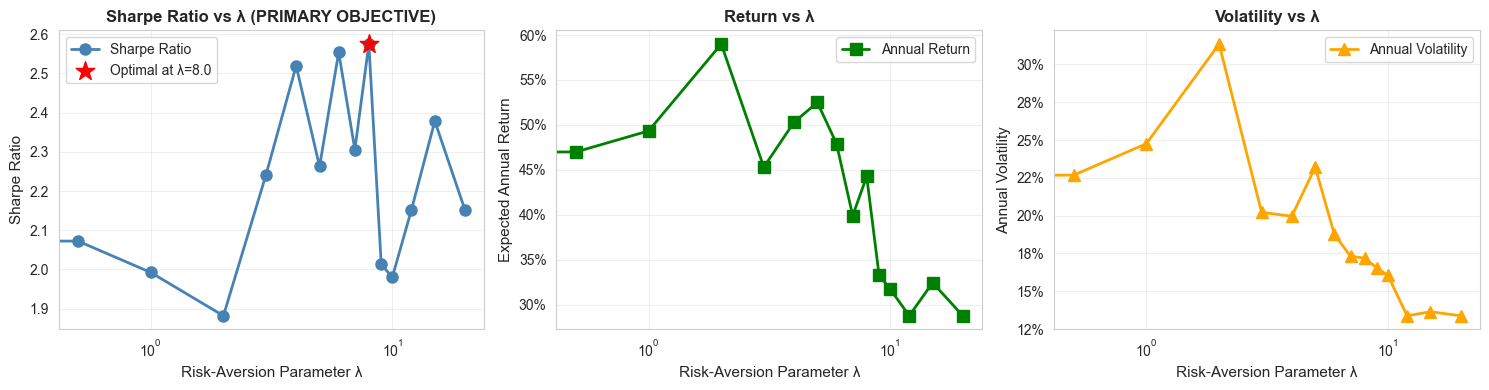


✓ Plot saved to 'lambda_sweep_analysis.png'


In [ ]:
# ============================================================================
# VISUALIZATION: SHARPE RATIO vs LAMBDA (PRIMARY OBJECTIVE)
# ============================================================================

lambdas = sorted(results_dict.keys())
sharpes = [results_dict[l]['sharpe'] for l in lambdas]
returns = [results_dict[l]['mu_ann'] for l in lambdas]
vols = [results_dict[l]['std_ann'] for l in lambdas]

# Find optimal lambda
optimal_idx = np.argmax(sharpes)
optimal_lambda = lambdas[optimal_idx]
optimal_sharpe = sharpes[optimal_idx]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Sharpe Ratio vs Lambda
axes[0].plot(lambdas, sharpes, 'o-', linewidth=2, markersize=8, color='steelblue', label='Sharpe Ratio')
axes[0].scatter([optimal_lambda], [optimal_sharpe], s=200, marker='*', color='red', 
               label=f'Optimal at λ={optimal_lambda}', zorder=5)
axes[0].set_xlabel('Risk-Aversion Parameter λ', fontsize=11)
axes[0].set_ylabel('Sharpe Ratio', fontsize=11)
axes[0].set_title('Sharpe Ratio vs λ (PRIMARY OBJECTIVE)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xscale('log')

# Plot 2: Return vs Lambda
axes[1].plot(lambdas, returns, 's-', linewidth=2, markersize=8, color='green', label='Annual Return')
axes[1].set_xlabel('Risk-Aversion Parameter λ', fontsize=11)
axes[1].set_ylabel('Expected Annual Return', fontsize=11)
axes[1].set_title('Return vs λ', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xscale('log')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Plot 3: Volatility vs Lambda
axes[2].plot(lambdas, vols, '^-', linewidth=2, markersize=8, color='orange', label='Annual Volatility')
axes[2].set_xlabel('Risk-Aversion Parameter λ', fontsize=11)
axes[2].set_ylabel('Annual Volatility', fontsize=11)
axes[2].set_title('Volatility vs λ', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_xscale('log')
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.savefig('figures/lambda_sweep_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to 'lambda_sweep_analysis.png'")